
# BE Meteo 
## HERVIOUX, SOURDEVAL, MANCIET, DUC-MARTIN, LEFAUCONNIER

In [216]:
path_data <- paste(readLines("path.txt"), collapse = "\n")
path_data

Warning message in readLines("path.txt"):
“incomplete final line found on 'path.txt'”


[1] "/mnt/c/Users/adrie/Downloads/donnees-synop-essentielles-omm.csv"

In [217]:
#install.packages("data.table")
library(data.table)
dataset_meteo <- fread(path_data)
head(dataset_meteo)

ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,⋯,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
<int>,<dttm>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>
7690,2017-04-05 09:00:00,101580,100,2,90,1.3,289.95,285.25,74,⋯,2,Nice,06088,Métropole Nice Côte d'Azur,200030195,Alpes-Maritimes,06,Provence-Alpes-Côte d'Azur,93,4
61998,2017-04-05 09:00:00,102720,-200,8,320,20.1,285.65,281.95,78,⋯,29,,,,NA,,,,NA,4
78925,2018-04-04 03:00:00,101420,60,1,100,3.6,298.45,295.15,82,⋯,3,Le Lamentin,97213,CA du Centre de la Martinique,249720061,Martinique,972,Martinique,2,4
61998,2018-04-05 03:00:00,101190,40,1,290,5.1,278.15,272.75,68,⋯,29,,,,NA,,,,NA,4
7690,2018-04-05 06:00:00,101240,-20,5,320,1.6,284.25,280.15,76,⋯,2,Nice,06088,Métropole Nice Côte d'Azur,200030195,Alpes-Maritimes,06,Provence-Alpes-Côte d'Azur,93,4
7149,2018-04-08 03:00:00,100730,-20,5,30,2.3,285.55,283.25,86,⋯,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,4


# 1 - Description des données
   
Idées :
- Présentation des données (nombre, type (température pression, lieux...))
- Agrégation des valeurs (par ID station météo, par région ?)
- Carte de la France avec lieux des stations
- Carte avec les températures/pression moyenne/min/max des stations
- Données manquantes

In [218]:
df_meteo <- data.frame(dataset_meteo)
df_meteo <- df_meteo[order(df_meteo$Date), ] # Trier les valeurs par ordre chronologique
head(df_meteo)

,ID.OMM.station,Date,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Type.de.tendance.barométrique,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,⋯,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.,mois_de_l_annee
,<int>,<dttm>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>
452812,7037,2015-08-04,101260,40,0,360,2.1,289.65,287.65,88,⋯,151,Boos,76116,Métropole Rouen Normandie,200023414,Seine-Maritime,76,Normandie,28,8
452813,7168,2015-08-04,100980,-160,8,120,2.4,295.85,284.25,48,⋯,112,Barberey-Saint-Sulpice,10030,Communauté d'agglomération Troyes Champagne Métropole,200069250,Aube,10,Grand Est,44,8
452814,89642,2015-08-04,99140,340,1,120,14.9,265.75,260.45,62,⋯,43,,,,NA,,,,NA,8
459165,7149,2015-08-04,101090,-20,8,310,3.2,297.75,287.55,53,⋯,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,8
459167,7222,2015-08-04,101620,130,3,270,2.3,289.65,286.95,84,⋯,26,Saint-Aignan-Grandlieu,44150,Nantes Métropole,244400404,Loire-Atlantique,44,Pays de la Loire,52,8
459169,7299,2015-08-04,101390,10,0,170,2.8,293.25,288.45,74,⋯,263,Blotzheim,68042,Communauté d'agglomération Saint-Louis Agglomération,200066058,Haut-Rhin,68,Grand Est,44,8


In [219]:
# colnames(df_meteo)

In [220]:
cat("Nombre de lignes de données :", nrow(df_meteo), "\n")
cat("Nombre de paramètres :", ncol(df_meteo), "\n")
cat("\tdont 14 paramètres décrivant l'emplacement de la station météo\n")
cat("\tdont 19 paramètres relatifs aux nuages/à la nébulosité (+ 4 hauteurs de bases)\n")
cat("\tdont 14 paramètres relatifs à la température\n")
cat("\tdont 7 paramètres relatifs à la pression/barométrie\n")
cat("\tdont 5 paramètres relatifs au vent/rafales\n")
cat("\tdont 5 paramètres relatifs à la pluie (précipitations)\n")
cat("\tdont 3 paramètres relatifs à la neige\n")
cat("\tdont 2 paramètres relatifs à l'humidité/rosée\n")
cat("\t + Date, mois_de_l_annee, Visibilité.horizontale, Temps.présent, Temps.passé.1, Temps.passé.2, Géopotentiel, Etat.du.sol, Phénomène.spécial.1, Phénomène.spécial.2, Phénomène.spécial.3, Phénomène.spécial.4, Temps.passé.1.1, Temps.présent.1")

# TODO : /!\ Erreur 1 paramètre a dû être compté 2 fois (82 colonnes en tout et mon décompte arrive à 83 paramètres)

Nombre de lignes de données : 1719567 
Nombre de paramètres : 82 
	dont 14 paramètres décrivant l'emplacement de la station météo
	dont 19 paramètres relatifs aux nuages/à la nébulosité (+ 4 hauteurs de bases)
	dont 14 paramètres relatifs à la température
	dont 7 paramètres relatifs à la pression/barométrie
	dont 5 paramètres relatifs au vent/rafales
	dont 5 paramètres relatifs à la pluie (précipitations)


	dont 3 paramètres relatifs à la neige
	dont 2 paramètres relatifs à l'humidité/rosée
	 + Date, mois_de_l_annee, Visibilité.horizontale, Temps.présent, Temps.passé.1, Temps.passé.2, Géopotentiel, Etat.du.sol, Phénomène.spécial.1, Phénomène.spécial.2, Phénomène.spécial.3, Phénomène.spécial.4, Temps.passé.1.1, Temps.présent.1

### Description des stations météo

In [221]:
# Caractéristiques des stations météo
df_stations <- df_meteo[c('ID.OMM.station', 'Coordonnees', 'Nom', 'Latitude', 'Longitude', 'Altitude', 'communes..name.', 'communes..code.', 'EPCI..name.', 'EPCI..code.', 'department..name.', 'department..code.', 'region..name.', 'region..code.')]
df_unique_stations <- df_stations[!duplicated(df_stations[c('ID.OMM.station')]), ]
cat("Nombre de stations météo :", nrow(df_unique_stations))
head(df_unique_stations[order(df_unique_stations$Nom), ])

Nombre de stations météo : 62

,ID.OMM.station,Coordonnees,Nom,Latitude,Longitude,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.
,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
1625518,7005,"50.136, 1.834",ABBEVILLE,50.13600,1.834000,69,Abbeville,80001,Communauté d'agglomération de la Baie de Somme,200070993,Somme,80,Hauts-de-France,32
671481,7761,"41.918, 8.792667",AJACCIO,41.91800,8.792667,5,Ajaccio,2A004,Communauté d'agglomération du Pays Ajaccien,242010056,Corse-du-Sud,2A,Corse,94
1474178,7139,"48.4455, 0.110167",ALENCON,48.44550,0.110167,143,Cerisé,61077,Communauté urbaine d'Alençon,246100663,Orne,61,Normandie,28
459169,7299,"47.614333, 7.51",BALE-MULHOUSE,47.61433,7.510000,263,Blotzheim,68042,Communauté d'agglomération Saint-Louis Agglomération,200066058,Haut-Rhin,68,Grand Est,44
1715295,7790,"42.540667, 9.485167",BASTIA,42.54067,9.485167,10,Lucciana,2B148,Communauté de communes de Marana-Golo,200036499,Haute-Corse,2B,Corse,94
1386709,7207,"47.294333, -3.218333",BELLE ILE-LE TALUT,47.29433,-3.218333,34,Bangor,56009,Communauté de communes de Belle-Île-en-Mer,245600465,Morbihan,56,Bretagne,53


### Carte des stations météo

In [222]:
#install.packages(c("ggplot2", "maps", "ggmap"))
library(ggplot2)
library(maps)
library(ggmap)

options(repr.plot.width = 20, repr.plot.height = 10)

data_points <- data.frame(
  lon = df_unique_stations$Longitude,
  lat = df_unique_stations$Latitude,
  Ville = df_unique_stations$Nom
)

world <- map_data("world")

ggplot() +
  geom_polygon(data = world, aes(x = long, y = lat, group = group),
               fill = "lightgray", color = "white") +
  geom_point(data = data_points, aes(x = lon, y = lat, color = Ville), size = 1) +
  theme_minimal() +
  theme(legend.position = "none") +
  ggtitle("Carte des stations météo")


# Zoom sur l'hexagone  
data_points_metropole <- data_points[(data_points$lat<=52)&(data_points$lat>=42)&(data_points$lon<=10)&(data_points$lon>=-10),]
france <- map_data("france")

ggplot() +
  geom_polygon(data = france, aes(x = long, y = lat, group = group),
               fill = "lightgray", color = "white") +
  geom_point(data = data_points_metropole, aes(x = lon, y = lat, color = Ville), size = 3) +
  theme_minimal() +
  # theme(legend.position = "none") +
  coord_fixed(ratio = 1.2)+
  ggtitle("Carte des stations météo de France métropolitaine")

ERROR: Error in library(maps): there is no package called ‘maps’


### Relevé de températures par station

In [ ]:
for (ville in unique(df_meteo$Nom)){
  plot(
    df_meteo$Date[df_meteo$Nom==ville],
    df_meteo$`Température`[df_meteo$Nom==ville],
    xlab = "Date",
    ylab = "Température",
    main = ville,
    type = "l",
)}

### Valeurs moyennes des grandeurs mesurées par station

In [ ]:
# install.packages("dplyr")
library(dplyr)

df_grouped <- df_meteo %>%
  group_by(ID.OMM.station) %>%
  summarise(n_mesures = n(),
            T_mean = mean(`Température`,na.rm = TRUE),
            T_min = min(`Température`,na.rm = TRUE),
            T_max = max(`Température`,na.rm = TRUE),
            P_mean = mean(Pression.au.niveau.mer,na.rm = TRUE),
            nebulosite_mean = mean(Nebulosité.totale, na.rm = TRUE)
            )

head(df_grouped)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ID.OMM.station,n_mesures,T_mean,T_min,T_max,P_mean,nebulosite_mean
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7005,29191,284.7995,265.65,314.35,101652.1,72.55759
7015,29365,285.1373,265.55,314.55,101631.3,96.49914
7020,29041,285.9265,270.05,305.25,101625.5,69.14118
7027,29208,285.0625,266.45,312.65,101687.4,94.13673
7037,29375,284.6429,264.15,314.05,101687.3,94.67241
7072,29387,284.8362,262.55,314.05,101703.0,97.29704


### Carte des températures extrêmes mesurées par station

In [ ]:
df_station_stats <- merge(x = df_unique_stations, y = df_grouped, by = "ID.OMM.station", all = TRUE)

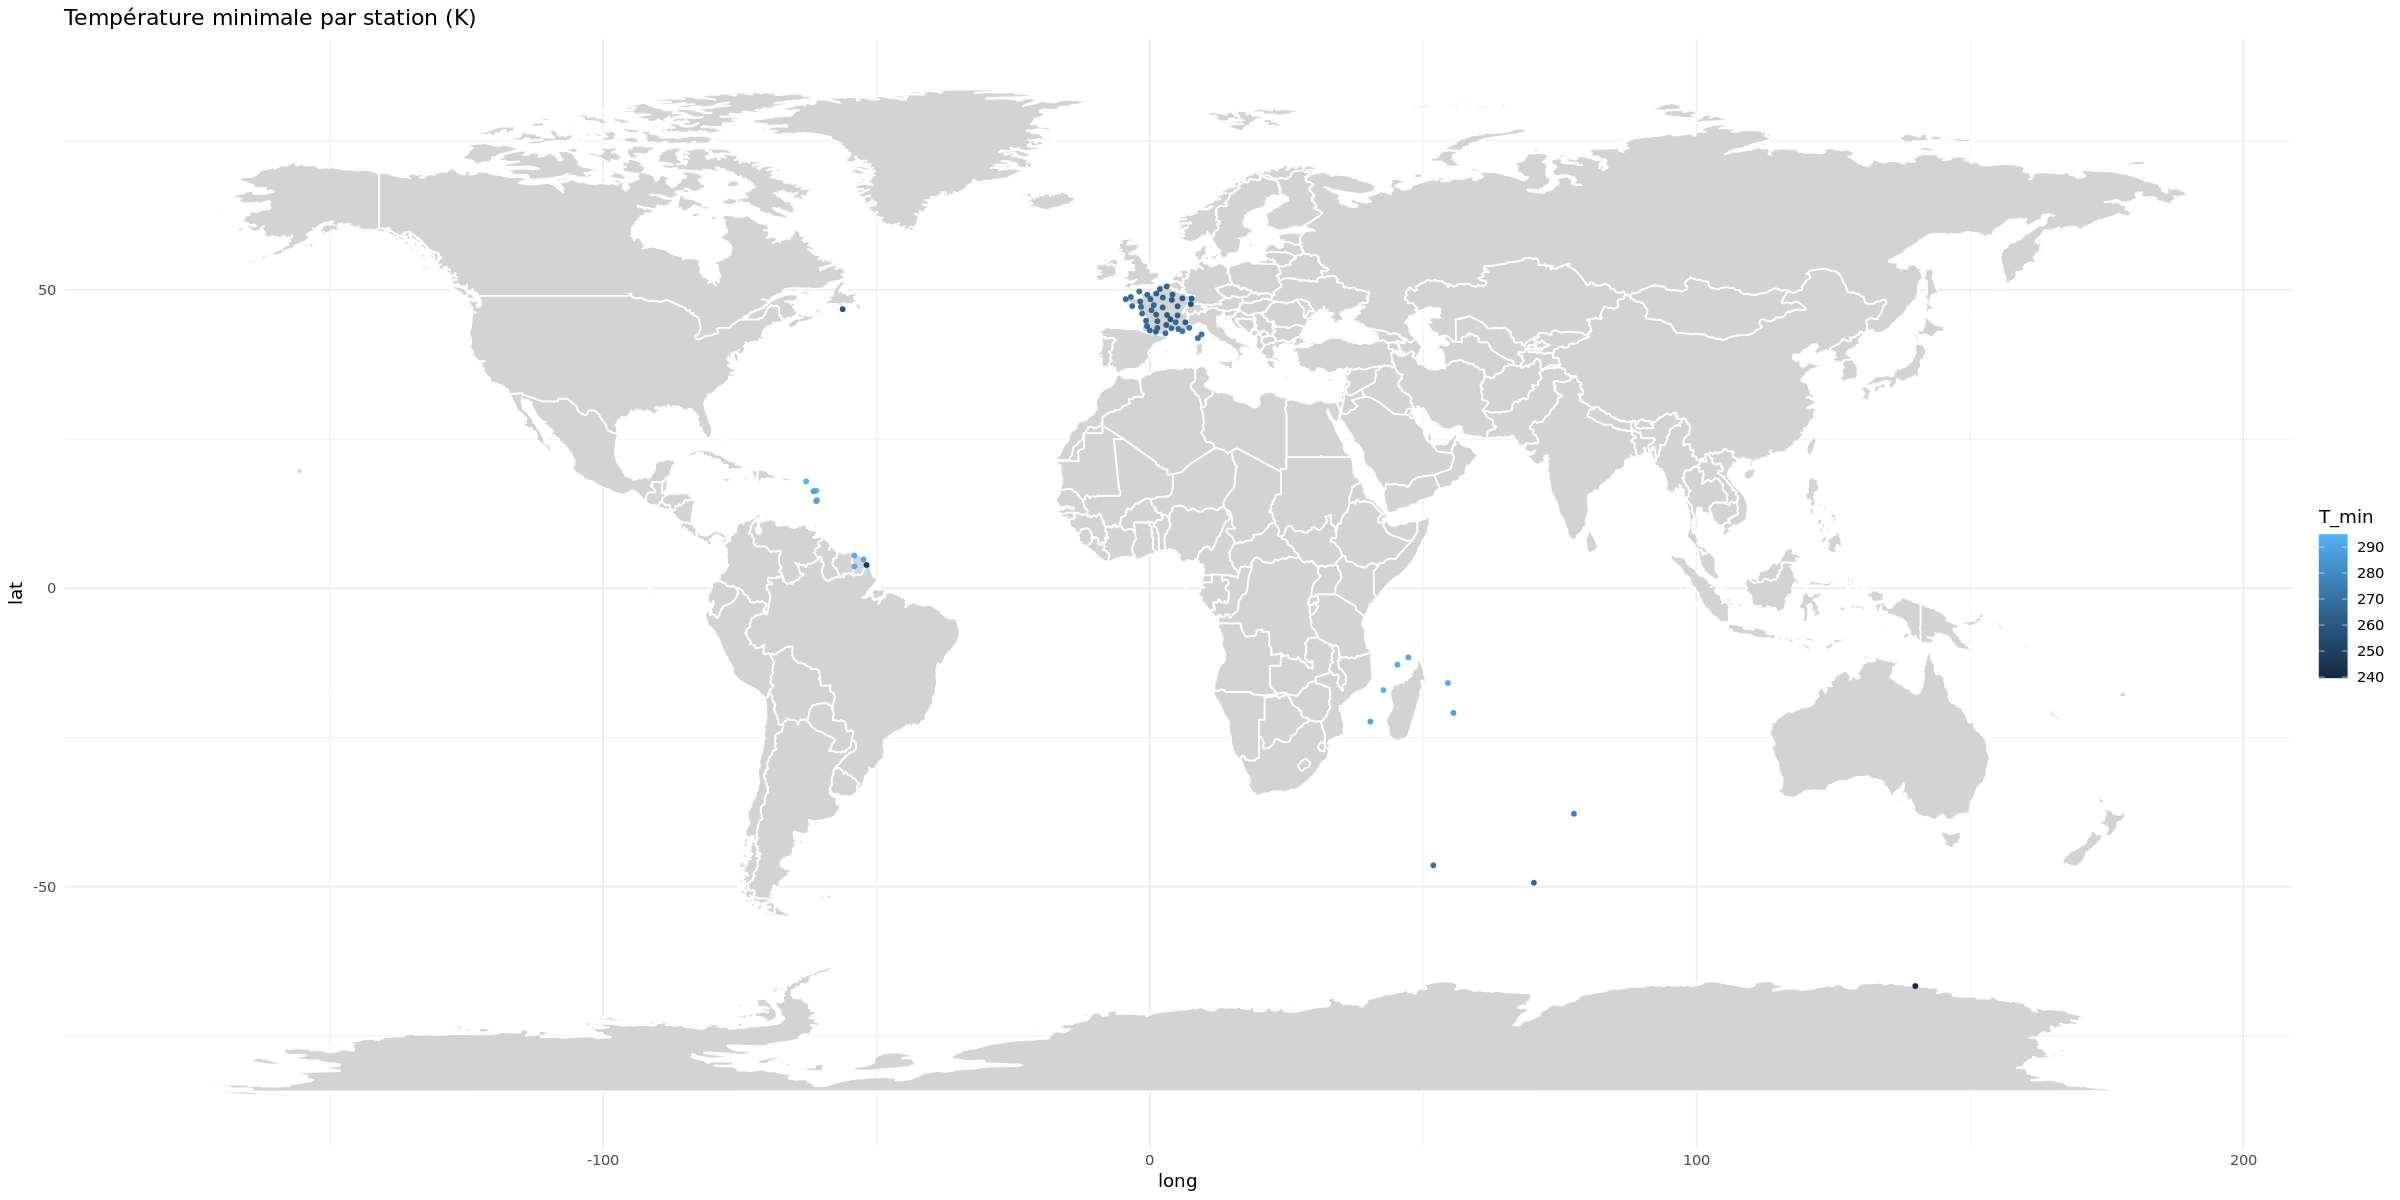

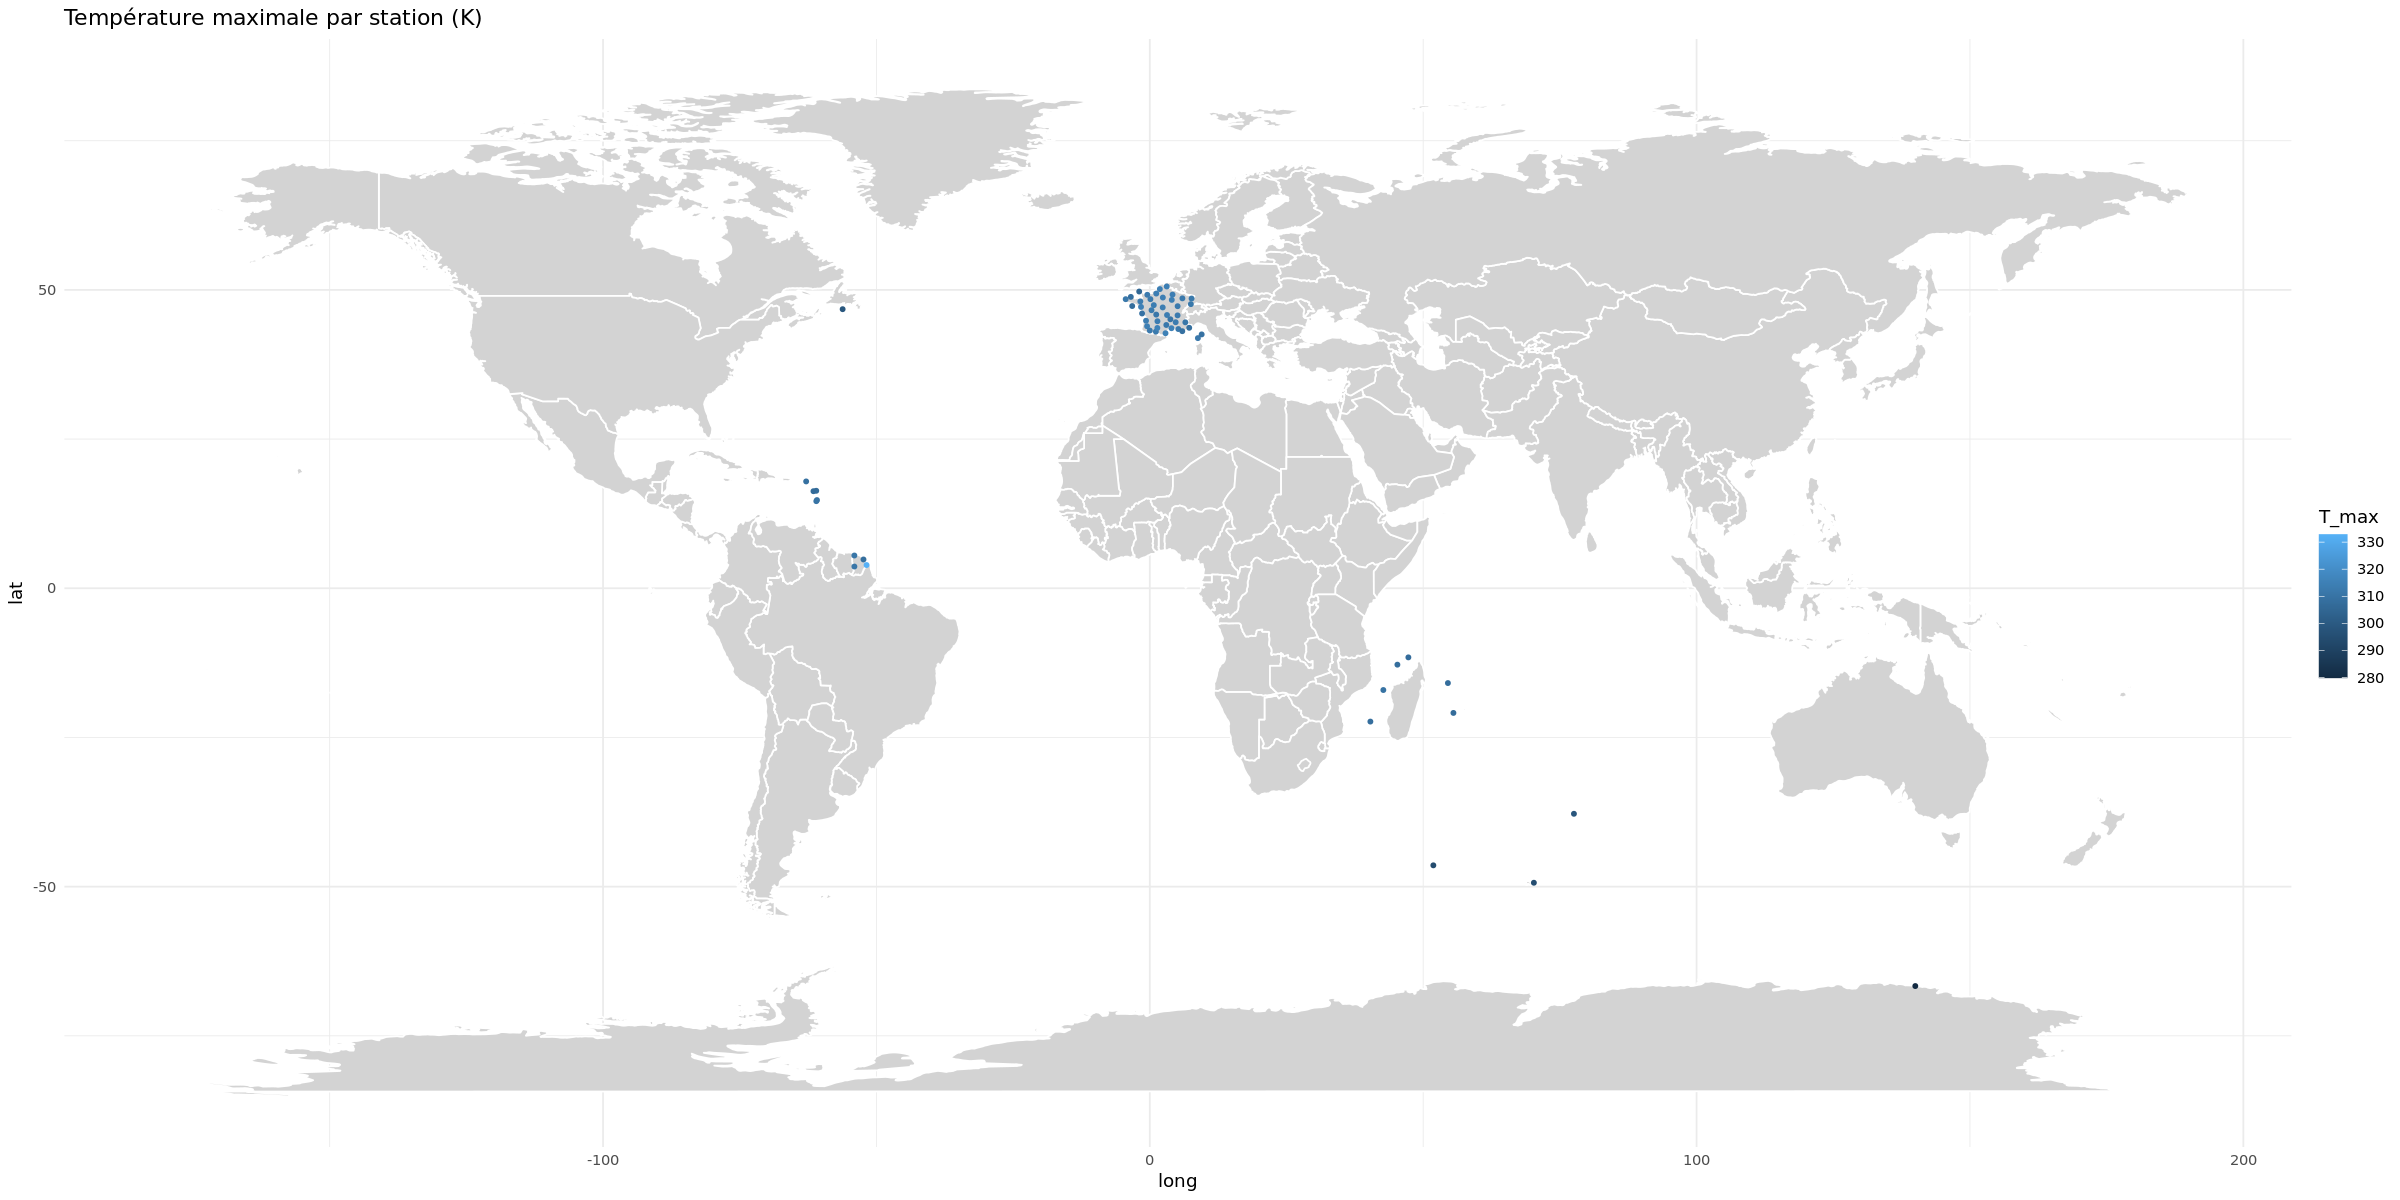

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

world <- map_data("world")

ggplot() +
  geom_polygon(data = world, aes(x = long, y = lat, group = group),
               fill = "lightgray", color = "white") +
  geom_point(data = df_station_stats, aes(x = Longitude, y = Latitude, color = T_min), size = 1) +
  theme_minimal() +
  # theme(legend.position = "none")+
  ggtitle("Température minimale par station (K)")

ggplot() +
  geom_polygon(data = world, aes(x = long, y = lat, group = group),
               fill = "lightgray", color = "white") +
  geom_point(data = df_station_stats, aes(x = Longitude, y = Latitude, color = T_max), size = 1) +
  theme_minimal() +
  # theme(legend.position = "none")+
  ggtitle("Température maximale par station (K)")

In [ ]:
summary(dataset_meteo)

 ID OMM station       Date                     Pression au niveau mer
 Min.   : 7005   Min.   :2015-08-04 00:00:00   Min.   : 93850        
 1st Qu.: 7207   1st Qu.:2018-03-14 03:00:00   1st Qu.:101180        
 Median : 7577   Median :2020-09-25 06:00:00   Median :101600        
 Mean   :26062   Mean   :2020-09-15 03:41:58   Mean   :101577        
 3rd Qu.:61976   3rd Qu.:2023-03-21 21:00:00   3rd Qu.:102090        
 Max.   :89642   Max.   :2025-09-03 21:00:00   Max.   :107570        
                                               NA's   :94370         
 Variation de pression en 3 heures Type de tendance barométrique
 Min.   :-2840.00                  Min.   : 0.000               
 1st Qu.:  -60.00                  1st Qu.: 2.000               
 Median :   10.00                  Median : 3.000               
 Mean   :   15.39                  Mean   : 4.297               
 3rd Qu.:   90.00                  3rd Qu.: 7.000               
 Max.   : 2990.00                  Max.   :10.000 

# 2. Un calcul et étude d'estimateur

Thibault

Température moyenne ou pluie moyenne en fonction des régions

In [ ]:
#library(dplyr)

data_temp <- data.frame(
  date = df_meteo$Date,
  temp = df_meteo$Température,
  mois = df_meteo$mois_de_l_annee
)

moy<-list()
for ( j in 1:9 ) {
  moy<-list()
  data_filter_mois <- filter(data_temp, mois==j)
  for (i in 2015:2025) {
	  data_filtered <- filter(data_filter_mois, format(date,"%Y")==sprintf("%d", i))
    moy[[as.character(i)]] <- mean(data_filtered$temp, na.rm = TRUE)
  }
  plot(2015:2025,moy,main=sprintf('Moyenne de température sur les mois de %d pour toutes les stations',j))
}

# 3. Des tests statistiques (au moins un sur un paramètre et une ANOVA)

Colin

# 4. Une régression et étude de corrélation

Pression et précipitations ?

Anaïs

# 5. Une ACP et une PLS

Nuages/nébulosité

Adrien

$\small\textbf{Introduction : }$ Commençons par analyser les corrélations entre différentes variables deux à deux autour du sujet de la nébulosité. 

In [232]:
sub <- df_meteo[df_meteo$Date > "2023-01-01 00:00:00 UTC" & df_meteo$Date <= "2023-12-31 00:00:00 UTC" & df_meteo$Nom == "MONT-DE-MARSAN", ]
# colnames(sub)
# temps <- sub$Date
# temperature  <- sub$`Température...C.`
# pression <- sub$Pression.station
# humidite <- sub$`Humidité`
# rosee <- sub$`Point.de.rosée`
# visibilite <- sub$`Visibilité.horizontale`
# vent <- sub$Vitesse.du.vent.moyen.10.mn
# # nuages <- sub$`Nébulosité.couche.nuageuse.1`
# nuages_sub <- sub$`Nébulosité..des.nuages.de.l..étage.inférieur`
# nuages_haut <- sub$`Hauteur.de.la.base.des.nuages.de.l.étage.inférieur`
# pluie_3 <- sub$`Précipitations.dans.les.3.dernières.heures`
# pluie_6 <- sub$`Précipitations.dans.les.6.dernières.heures`
# pluie_12 <- sub$`Précipitations.dans.les.12.dernières.heures`
# pluie_24 <- sub$`Précipitations.dans.les.24.dernières.heures`
# pluie_1 <- sub$`Précipitations.dans.la.dernière.heure`
# nuages_1 <- sub$`Nébulosité.couche.nuageuse.1`
# nuages_2 <- sub$`Nébulosité.couche.nuageuse.2`
# nuages_3 <- sub$`Nébulosité.couche.nuageuse.3`
# nuages_4 <- sub$`Nébulosité.couche.nuageuse.4`

# indice_nuageux <- nuages_haut/visibilite


# X <- data.frame( 
#   # temperature = temperature,
#   nuages_1 = nuages_1,
#   humidite = humidite,   
#   pluie_24 = pluie_24 + pluie_1 + pluie_12 + pluie_3 + pluie_6,
#   indice_nuageux = indice_nuageux 
# )

# # nrow(X)
# X_clean <- na.omit(X)



# #table(format(sub$Date[complete.cases(X)], "%m"))

# pairs(X_clean)
# cor(X_clean)


# # plot(temps, temp, type = "b")
# # hist(nuages)
# # plot(temps, nuages)
# # plot(pression, clean_nuages)


nuages_cols <- c("Nébulosité.couche.nuageuse.1",
                 "Nébulosité.couche.nuageuse.2",
                 "Nébulosité.couche.nuageuse.3",
                 "Nébulosité.couche.nuageuse.4",
                 "Hauteur.de.base.1",
                 "Hauteur.de.base.2",
                 "Hauteur.de.base.3",
                 "Hauteur.de.base.4")

X_nuages <- sub[, nuages_cols]
head(X_nuages)
# Remplacer NA dans les nébulosités par 0 (pas de nuage)
for(i in 1:4){
  X_nuages[,i][is.na(X_nuages[,i])] <- 0
}

# Pour les hauteurs, on peut remplacer NA par 0 ou laisser NA si absence
for(i in 5:8){
  X_nuages[,i][is.na(X_nuages[,i])] <- 0
}

X_nuages$nebulosité_totale <- rowSums(X_nuages[,1:4])          # somme des couches
X_nuages$hauteur_moyenne <- rowMeans(X_nuages[,5:8])           # moyenne des hauteurs
X_nuages$couches_actives <- rowSums(X_nuages[,1:4] > 0)        # nombre de couches avec nuages

# X_nuages

,Nébulosité.couche.nuageuse.1,Nébulosité.couche.nuageuse.2,Nébulosité.couche.nuageuse.3,Nébulosité.couche.nuageuse.4,Hauteur.de.base.1,Hauteur.de.base.2,Hauteur.de.base.3,Hauteur.de.base.4
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1300717,6,NA,NA,NA,4320,NA,NA,NA
1662654,6,NA,NA,NA,4200,NA,NA,NA
740845,7,NA,NA,NA,4200,NA,NA,NA
1291188,8,NA,NA,NA,4020,NA,NA,NA
852900,7,8,NA,NA,3660,4260,NA,NA
552287,7,8,NA,NA,3600,4380,NA,NA


$\small\textbf{Lancement de l'ACP}$

Nous allons utiliser la librairie factominer. 

In [242]:
library(FactoMineR)

# ACP sur les 3 variables nuages
res_pca_nuages <- PCA(X_nuages[, c("nebulosité_totale", "hauteur_moyenne", "couches_actives")],
                      scale.unit = TRUE, graph = TRUE)

# Variance expliquée
res_pca_nuages$eig

# Cercle des corrélations
var.coord <- res_pca_nuages$var$coord[,1:2]
plot(var.coord, type="n", xlab="PC1", ylab="PC2", main="Cercle des corrélations")
arrows(0,0,var.coord[,1], var.coord[,2], length=0.1, col="red")
text(var.coord[,1]*1.1, var.coord[,2]*1.1, labels=rownames(var.coord), col="red")

# Individus
ind.coord <- res_pca_nuages$ind$coord[,1:2]
plot(ind.coord, xlab="PC1", ylab="PC2", main="Individus - focus nuages", pch=19, col="blue")



# res.pca <- PCA(X_clean, scale.unit = TRUE, graph = FALSE)

# # Valeurs propres et variance expliquée
# res.pca$eig

# # Coordonnées des variables sur les 2 premiers axes
# var.coord <- res.pca$var$coord[, 1:2]

# # Cercle unité
# theta <- seq(0, 2*pi, length=100)
# plot(cos(theta), sin(theta), type='l', asp=1, xlab="PC1", ylab="PC2")  # cercle unité
# abline(h=0, v=0, col="grey", lty=2)

# # Ajouter les variables
# arrows(0, 0, var.coord[,1], var.coord[,2], length=0.1, col="red")
# text(var.coord[,1]*1.1, var.coord[,2]*1.1, labels=rownames(var.coord), col="red")

# ind.coord <- res.pca$ind$coord[, 1:2]

# plot(ind.coord, xlab="PC1", ylab="PC2", pch=20, col="black", scale = 30)
# arrows(0, 0, var.coord[,1], var.coord[,2], length=0.1, col="red")
# text(var.coord[,1]*1.1, var.coord[,2]*1.1, labels=rownames(var.coord), col="red")





,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,2.42371962,80.790654,80.79065
comp 2,0.49661146,16.553715,97.34437
comp 3,0.07966892,2.655631,100.00000


In [226]:
# install.packages("scatterplot3d")
# library(scatterplot3d)

# # Coordonnées sur les 3 premiers axes
# ind.coord <- res.pca$ind$coord[, 1:3]

# # Graphique 3D
# scatterplot3d(ind.coord[,1], ind.coord[,2], ind.coord[,3],
#               xlab="PC1", ylab="PC2", zlab="PC3",
#               color="blue", pch=19)

# var.coord <- res.pca$var$coord[, c(1,3)]  # PC1 et PC3
# plot(var.coord, type="n", xlab="PC1", ylab="PC3")
# arrows(0, 0, var.coord[,1], var.coord[,2], length=0.1, col="red")
# text(var.coord[,1]*1.1, var.coord[,2]*1.1, labels=rownames(var.coord), col="red")


# 6. Une méthode de clustering

Groupes de stations par rapport aux températures ? -> essayer de retrouver leur répartition géographique

Lise